<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/env_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Roads
Slope


In [39]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt

In [40]:
env_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Env/export/edges_gvi_no2_nf1.gpkg")
print(env_gdf.columns)

Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'gvi_final',
       'gvi_flag', 'gvi_final_norm', 'gvi_group', 'NO2_mean', 'natural_score',
       'geometry'],
      dtype='object')


In [41]:
# === 1. 定义 Min-Max 标准化函数 ===
def normalize_minmax(series):
    return (series - series.min()) / (series.max() - series.min())

# === 2. 标准化处理 ===
env_gdf['gvi_norm'] = normalize_minmax(env_gdf['gvi_final'])
env_gdf['no2_norm'] = normalize_minmax(env_gdf['NO2_mean'])
env_gdf['no2_inv'] = 1 - env_gdf['no2_norm']  # 越污染 → 得分越低

# === 3. 构建环境感知指数（权重：0.4 / 0.4 / 0.2）===
env_gdf['env_index'] = (
    0.5 * env_gdf['gvi_norm'] +
    0.3 * env_gdf['no2_inv'] +
    0.2 * env_gdf['natural_score']
)

# === 4. 添加分段标签（可选）===
env_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
env_labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']
env_gdf['env_group'] = pd.cut(env_gdf['env_index'], bins=env_bins, labels=env_labels, include_lowest=True)

In [42]:
print(env_gdf.columns)

Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'gvi_final',
       'gvi_flag', 'gvi_final_norm', 'gvi_group', 'NO2_mean', 'natural_score',
       'geometry', 'gvi_norm', 'no2_norm', 'no2_inv', 'env_index',
       'env_group'],
      dtype='object')


(np.float64(500712.9740324303),
 np.float64(564251.1956339173),
 np.float64(153673.7984079989),
 np.float64(203060.72389811068))

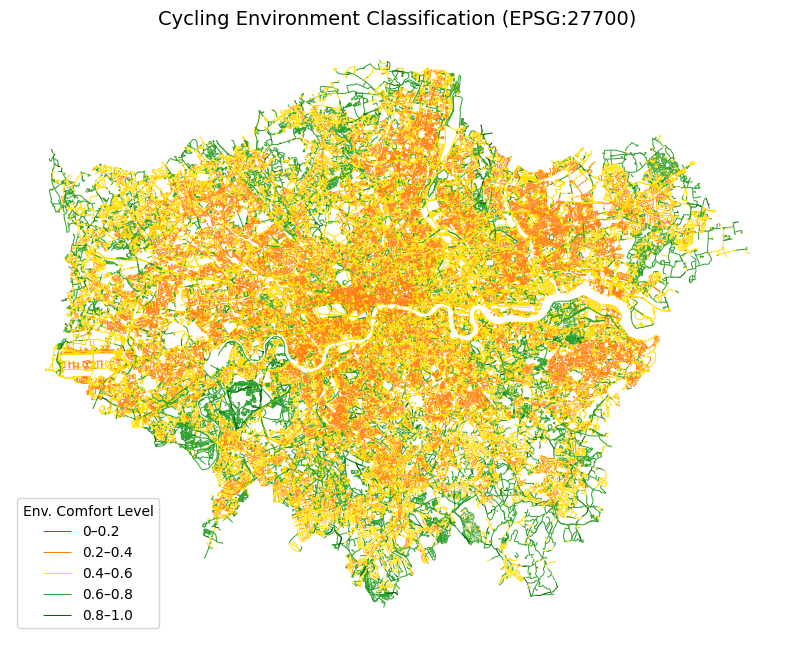

In [43]:
# 设置颜色对应每个等级（绿色 → 红色）
env_colors = {
    '0–0.2': '#d62728',   # 红
    '0.2–0.4': '#ff7f0e', # 橙
    '0.4–0.6': '#ffdf00', # 黄
    '0.6–0.8': '#2ca02c', # 绿
    '0.8–1.0': '#006400'  # 深绿
}

# 赋颜色列
env_gdf['color'] = env_gdf['env_group'].map(env_colors)

# 开始绘图
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
for label, color in env_colors.items():
    env_gdf[env_gdf['env_group'] == label].plot(
        ax=ax,
        color=color,
        linewidth=0.7,
        label=label
    )

# 添加图例和标题
ax.legend(title="Env. Comfort Level", loc='lower left')
ax.set_title("Cycling Environment Classification (EPSG:27700)", fontsize=14)
ax.axis("off")

In [44]:
# 保存高分图
plt.tight_layout()
fig.savefig("/content/drive/MyDrive/CASA0004_Cycling/figs/env_index_grouped532_27700.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

📊 环境指数描述统计：
count    292087.000000
mean          0.462309
std           0.114407
min           0.073113
25%           0.377288
50%           0.429386
75%           0.560954
max           0.987352
Name: env_index, dtype: float64


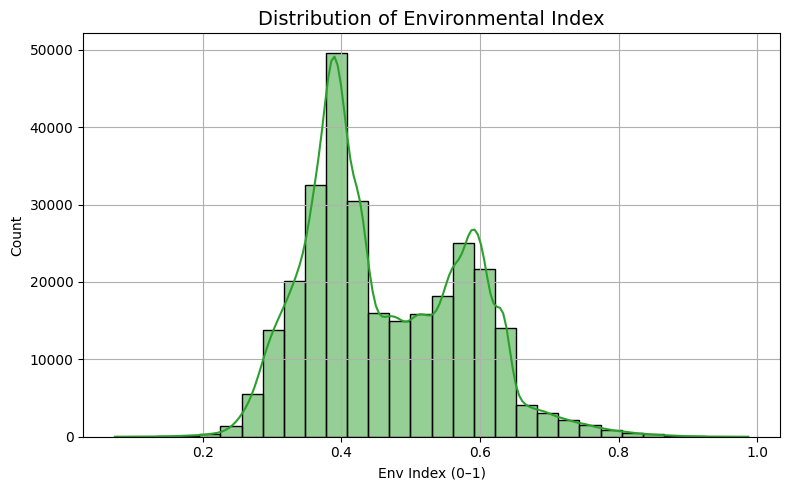

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 描述性统计 ===
print("📊 环境指数描述统计：")
print(env_gdf['env_index'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['env_index'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of Environmental Index", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

GVI描述统计：
count    292665.000000
mean         14.416467
std           6.420321
min           0.000000
25%          11.230470
50%          14.226629
75%          17.120068
max          60.330416
Name: gvi_final, dtype: float64


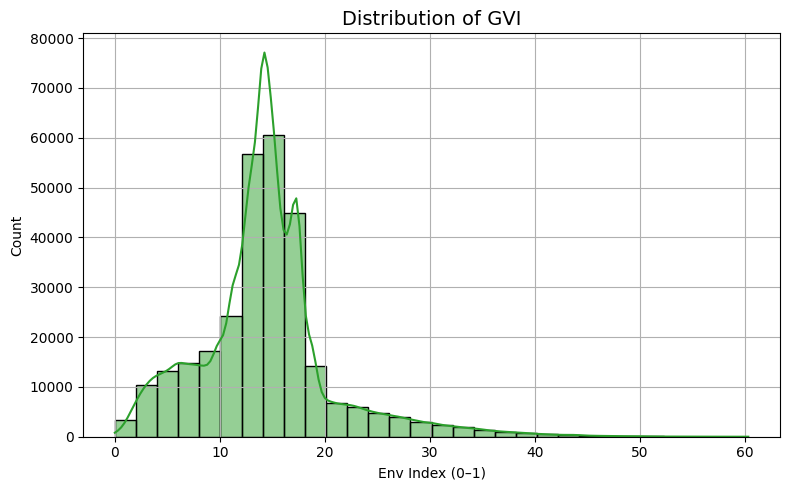

In [46]:
# === 1. 描述性统计 ===
print("GVI描述统计：")
print(env_gdf['gvi_final'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['gvi_final'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of GVI", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

📊 环境指数描述统计：
count    292125.000000
mean         21.247719
std           4.865328
min          12.893730
25%          18.010975
50%          20.144176
75%          23.153086
max          87.332474
Name: NO2_mean, dtype: float64


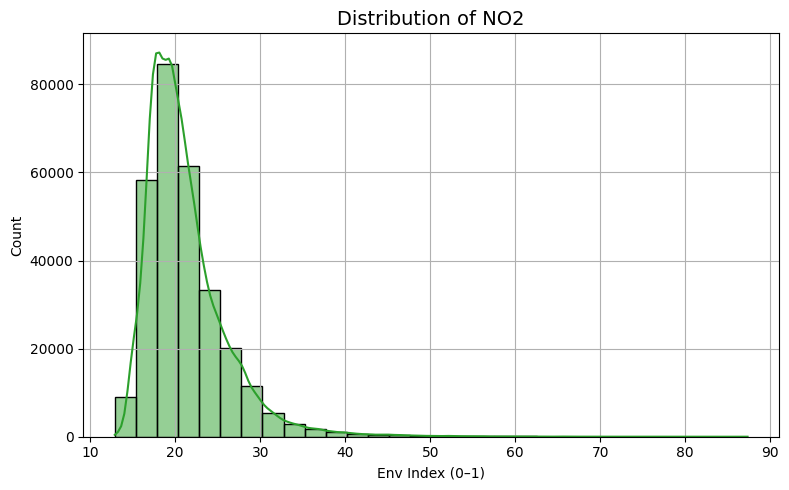

In [47]:
# === 1. 描述性统计 ===
print("📊 环境指数描述统计：")
print(env_gdf['NO2_mean'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['NO2_mean'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of NO2", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

📊 环境指数描述统计：
count    292703.000000
mean          0.382811
std           0.440183
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: natural_score, dtype: float64


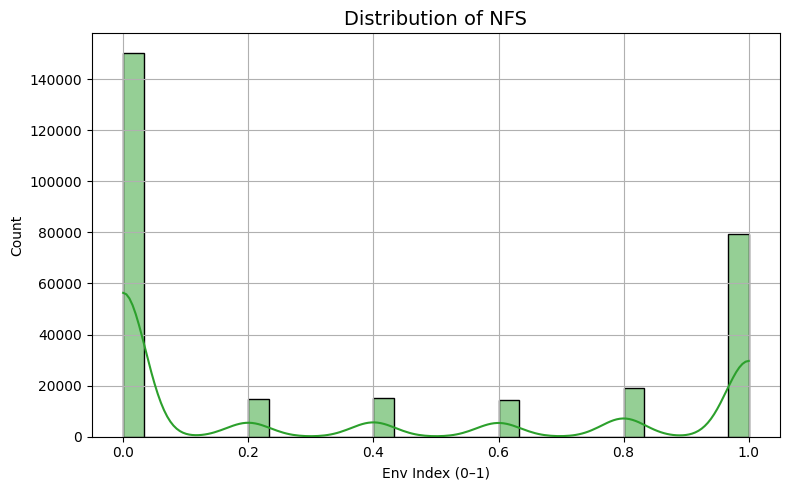

In [48]:
# === 1. 描述性统计 ===
print("📊 环境指数描述统计：")
print(env_gdf['natural_score'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['natural_score'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of NFS", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()